<a href="https://colab.research.google.com/github/reitezuz/18NES2-2025/blob/main/week_08/coco_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install keras keras-hub --upgrade -q

In [2]:


import os
os.environ["KERAS_BACKEND"] = "jax"



In [3]:
# @title
import os
from IPython.core.magic import register_cell_magic

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

In [4]:
print(os.environ.get("KERAS_BACKEND"))

jax



###Training a YOLO model from scratch
##Downloading the COCO dataset

In [5]:
import keras
import keras_hub

images_path = keras.utils.get_file(
    "coco",
    "http://images.cocodataset.org/zips/train2017.zip",
    extract=True,
)
annotations_path = keras.utils.get_file(
    "annotations",
    "http://images.cocodataset.org/annotations/annotations_trainval2017.zip",
    extract=True,
)

19336861798/19336861798 ━━━━━━━━━━━━━━━━━━━━ 484s 0us/step
252907541/252907541 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [6]:
import json

with open(f"{annotations_path}/annotations/instances_train2017.json", "r") as f:
    annotations = json.load(f)

images = {image["id"]: image for image in annotations["images"]}

def scale_box(box, width, height):
    scale = 1.0 / max(width, height)
    x, y, w, h = [v * scale for v in box]
    x += (height - width) * scale / 2 if height > width else 0
    y += (width - height) * scale / 2 if width > height else 0
    return [x, y, w, h]

metadata = {}
for annotation in annotations["annotations"]:
    id = annotation["image_id"]
    if id not in metadata:
        metadata[id] = {"boxes": [], "labels": []}
    image = images[id]
    box = scale_box(annotation["bbox"], image["width"], image["height"])
    metadata[id]["boxes"].append(box)
    metadata[id]["labels"].append(annotation["category_id"])
    metadata[id]["path"] = images_path + "/train2017/" + image["file_name"]
metadata = list(metadata.values())

In [7]:


len(metadata)



117266

In [8]:


min([len(x["boxes"]) for x in metadata])



1

In [9]:
max([len(x["boxes"]) for x in metadata])

93

In [10]:
max(max(x["labels"]) for x in metadata) + 1

91

In [11]:
metadata[435]

{'boxes': [[0.12471874999999999, 0.275, 0.57640625, 0.333703125],
  [0.0, 0.152078125, 0.7938125, 0.687640625],
  [0.0, 0.125140625, 1.0, 0.7498593750000001]],
 'labels': [17, 15, 2],
 'path': '/root/.keras/datasets/coco/train2017/000000171809.jpg'}

In [12]:
[keras_hub.utils.coco_id_to_name(x) for x in metadata[435]["labels"]]

['cat', 'bench', 'bicycle']

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.patches import Rectangle

color_map = {0: "gray"}

def label_to_color(label):
    if label not in color_map:
        h, s, v = (len(color_map) * 0.618) % 1, 0.5, 0.9
        color_map[label] = hsv_to_rgb((h, s, v))
    return color_map[label]

def draw_box(ax, box, text, color):
    x, y, w, h = box
    ax.add_patch(Rectangle((x, y), w, h, lw=2, ec=color, fc="none"))
    textbox = dict(fc=color, pad=1, ec="none")
    ax.text(x, y, text, c="white", size=10, va="bottom", bbox=textbox)

def draw_image(ax, image):
    ax.set(xlim=(0, 1), ylim=(1, 0), xticks=[], yticks=[], aspect="equal")
    image = plt.imread(image)
    height, width = image.shape[:2]
    hpad = (1 - height / width) / 2 if width > height else 0
    wpad = (1 - width / height) / 2 if height > width else 0
    extent = [wpad, 1 - wpad, 1 - hpad, hpad]
    ax.imshow(image, extent=extent)

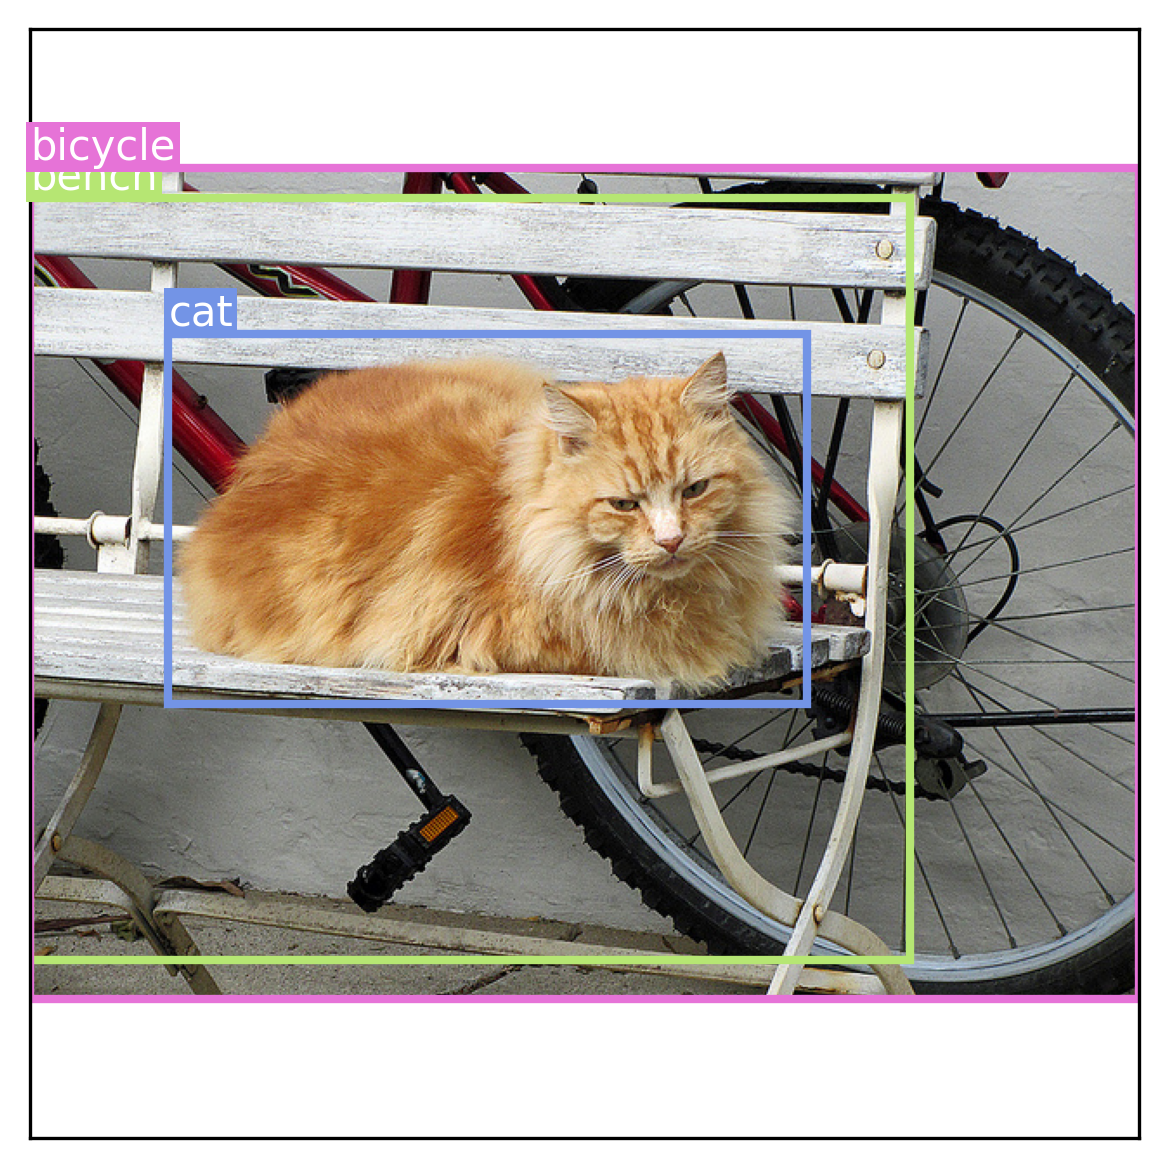

In [14]:
sample = metadata[435]
ig, ax = plt.subplots(dpi=300)
draw_image(ax, sample["path"])
for box, label in zip(sample["boxes"], sample["labels"]):
    label_name = keras_hub.utils.coco_id_to_name(label)
    draw_box(ax, box, label_name, label_to_color(label))
plt.show()

In [15]:
import random

metadata = list(filter(lambda x: len(x["boxes"]) <= 4, metadata))
random.shuffle(metadata)

Creating a YOLO model

In [16]:
image_size = 448

backbone = keras_hub.models.Backbone.from_preset(
    "resnet_50_imagenet",
)
preprocessor = keras_hub.layers.ImageConverter.from_preset(
    "resnet_50_imagenet",
    image_size=(image_size, image_size),
)

100%|██████████| 841/841 [00:00<00:00, 1.76MB/s]


100%|██████████| 90.3M/90.3M [00:03<00:00, 30.1MB/s]


In [17]:


from keras import layers

grid_size = 6
num_labels = 91

inputs = keras.Input(shape=(image_size, image_size, 3))
x = backbone(inputs)
x = layers.Conv2D(512, (3, 3), strides=(2, 2))(x)
x = keras.layers.Flatten()(x)
x = layers.Dense(2048, activation="relu", kernel_initializer="glorot_normal")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(grid_size * grid_size * (num_labels + 5))(x)
x = layers.Reshape((grid_size, grid_size, num_labels + 5))(x)
box_predictions = x[..., :5]
class_predictions = layers.Activation("softmax")(x[..., 5:])
outputs = {"box": box_predictions, "class": class_predictions}
model = keras.Model(inputs, outputs)

model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 448, 448,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_net_backbone    │ (None, 14, 14,    │ 23,561,152 │ input_layer_1[0]… │
│ (ResNetBackbone)    │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 6, 6, 512) │  9,437,696 │ res_net_backbone… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 18432)     │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │ 37,750,784 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3456)      │  7,081,344 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 6, 6, 96)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 6, 6, 91)  │          0 │ reshape[0][0]     │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 6, 6, 5)   │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 6, 6, 91)  │          0 │ get_item_1[0][0]  │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,830,976 (296.90 MB)

 Trainable params: 77,777,856 (296.70 MB)

 Non-trainable params: 53,120 (207.50 KB)

Readying the COCO data for the YOLO model

In [18]:
def to_grid(box):
    x, y, w, h = box
    cx, cy = (x + w / 2) * grid_size, (y + h / 2) * grid_size
    ix, iy = int(cx), int(cy)
    return (ix, iy), (cx - ix, cy - iy, w, h)

def from_grid(loc, box):
    (xi, yi), (x, y, w, h) = loc, box
    x = (xi + x) / grid_size - w / 2
    y = (yi + y) / grid_size - h / 2
    return (x, y, w, h)

In [19]:
import numpy as np
import math

class_array = np.zeros((len(metadata), grid_size, grid_size))
box_array = np.zeros((len(metadata), grid_size, grid_size, 5))

for index, sample in enumerate(metadata):
    boxes, labels = sample["boxes"], sample["labels"]
    for box, label in zip(boxes, labels):
        (x, y, w, h) = box
        left, right = math.floor(x * grid_size), math.ceil((x + w) * grid_size)
        bottom, top = math.floor(y * grid_size), math.ceil((y + h) * grid_size)
        class_array[index, bottom:top, left:right] = label

for index, sample in enumerate(metadata):
    boxes, labels = sample["boxes"], sample["labels"]
    for box, label in zip(boxes, labels):
        (xi, yi), (grid_box) = to_grid(box)
        box_array[index, yi, xi] = [*grid_box, 1.0]
        class_array[index, yi, xi] = label

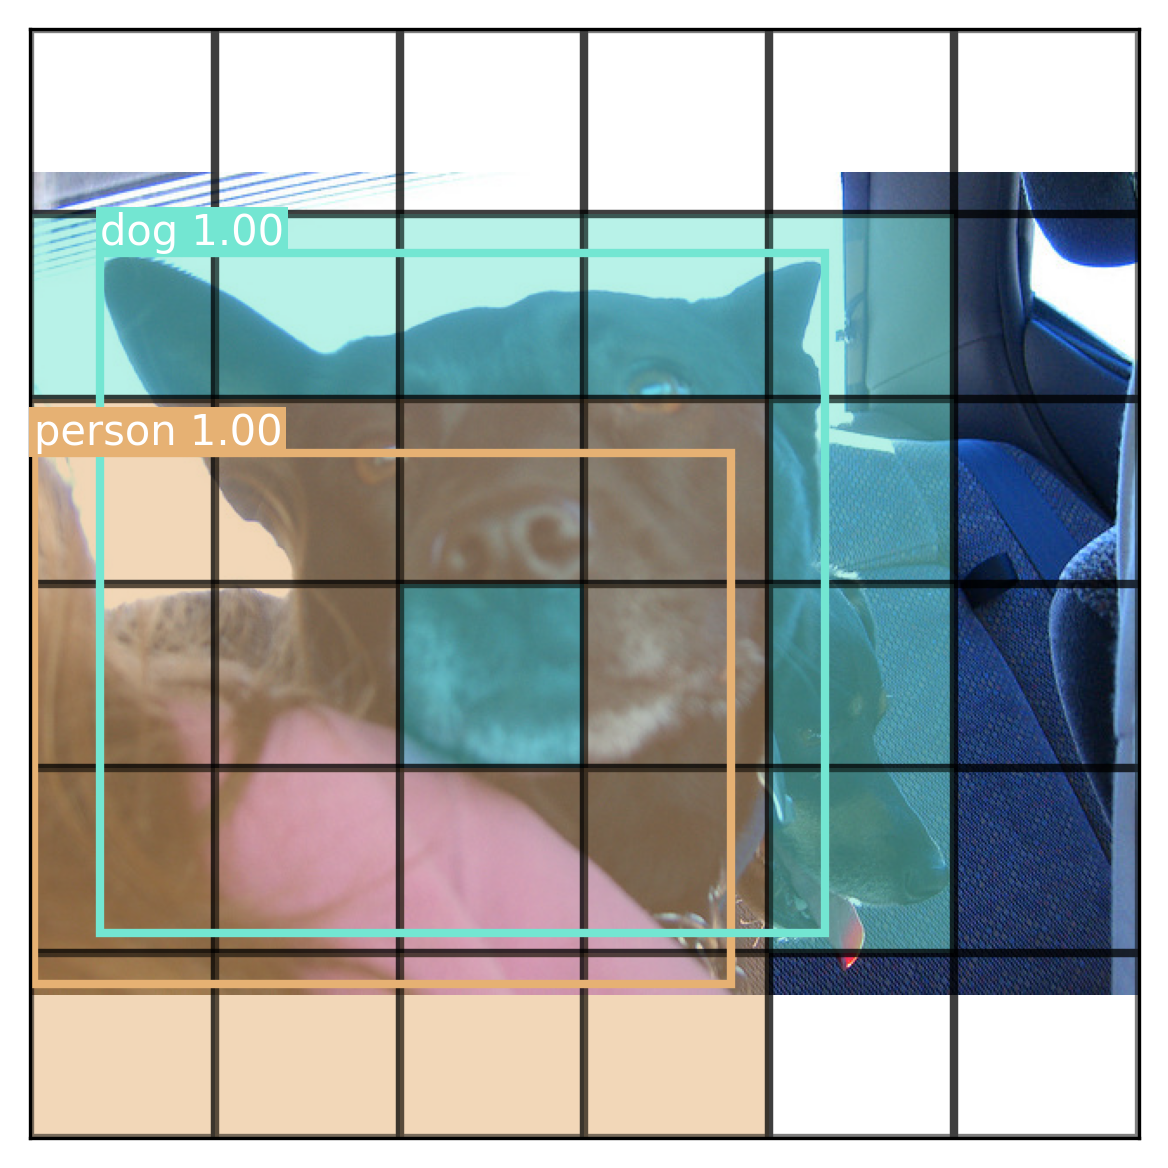

In [20]:
def draw_prediction(image, boxes, classes, cutoff=None):
    fig, ax = plt.subplots(dpi=300)
    draw_image(ax, image)
    for yi, row in enumerate(classes):
        for xi, label in enumerate(row):
            color = label_to_color(label) if label else "none"
            x, y, w, h = (v / grid_size for v in (xi, yi, 1.0, 1.0))
            r = Rectangle((x, y), w, h, lw=2, ec="black", fc=color, alpha=0.5)
            ax.add_patch(r)
    for yi, row in enumerate(boxes):
        for xi, box in enumerate(row):
            box, confidence = box[:4], box[4]
            if not cutoff or confidence >= cutoff:
                box = from_grid((xi, yi), box)
                label = classes[yi, xi]
                color = label_to_color(label)
                name = keras_hub.utils.coco_id_to_name(label)
                draw_box(ax, box, f"{name} {max(confidence, 0):.2f}", color)
    plt.show()

draw_prediction(metadata[0]["path"], box_array[0], class_array[0], cutoff=1.0)

In [21]:
import tensorflow as tf

def load_image(path):
    x = tf.io.read_file(path)
    x = tf.image.decode_jpeg(x, channels=3)
    return preprocessor(x)

images = tf.data.Dataset.from_tensor_slices([x["path"] for x in metadata])
images = images.map(load_image, num_parallel_calls=8)
labels = {"box": box_array, "class": class_array}
labels = tf.data.Dataset.from_tensor_slices(labels)

dataset = tf.data.Dataset.zip(images, labels).batch(16).prefetch(2)
val_dataset, train_dataset = dataset.take(500), dataset.skip(500)

Training the YOLO model

In [22]:


from keras import ops

def unpack(box):
    return box[..., 0], box[..., 1], box[..., 2], box[..., 3]

def intersection(box1, box2):
    cx1, cy1, w1, h1 = unpack(box1)
    cx2, cy2, w2, h2 = unpack(box2)
    left = ops.maximum(cx1 - w1 / 2, cx2 - w2 / 2)
    bottom = ops.maximum(cy1 - h1 / 2, cy2 - h2 / 2)
    right = ops.minimum(cx1 + w1 / 2, cx2 + w2 / 2)
    top = ops.minimum(cy1 + h1 / 2, cy2 + h2 / 2)
    return ops.maximum(0.0, right - left) * ops.maximum(0.0, top - bottom)

def intersection_over_union(box1, box2):
    cx1, cy1, w1, h1 = unpack(box1)
    cx2, cy2, w2, h2 = unpack(box2)
    intersection_area = intersection(box1, box2)
    a1 = ops.maximum(w1, 0.0) * ops.maximum(h1, 0.0)
    a2 = ops.maximum(w2, 0.0) * ops.maximum(h2, 0.0)
    union_area = a1 + a2 - intersection_area
    return ops.divide_no_nan(intersection_area, union_area)



In [23]:
def signed_sqrt(x):
    return ops.sign(x) * ops.sqrt(ops.absolute(x) + keras.config.epsilon())

def box_loss(true, pred):
    xy_true, wh_true, conf_true = true[..., :2], true[..., 2:4], true[..., 4:]
    xy_pred, wh_pred, conf_pred = pred[..., :2], pred[..., 2:4], pred[..., 4:]
    no_object = conf_true == 0.0
    xy_error = ops.square(xy_true - xy_pred)
    wh_error = ops.square(signed_sqrt(wh_true) - signed_sqrt(wh_pred))
    iou = intersection_over_union(true, pred)
    conf_target = ops.where(no_object, 0.0, ops.expand_dims(iou, -1))
    conf_error = ops.square(conf_target - conf_pred)
    error = ops.concatenate(
        (
            ops.where(no_object, 0.0, xy_error * 5.0),
            ops.where(no_object, 0.0, wh_error * 5.0),
            ops.where(no_object, conf_error * 0.5, conf_error),
        ),
        axis=-1,
    )
    return ops.sum(error, axis=(1, 2, 3))

In [24]:


model.compile(
    optimizer=keras.optimizers.Adam(2e-4),
    loss={"box": box_loss, "class": "sparse_categorical_crossentropy"},
)
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=4,
)



Epoch 1/4
1460/3201 ━━━━━━━━━━━━━━━━━━━━ 18:03 622ms/step - box_loss: 6.0836 - class_loss: 2.7577 - loss: 8.8350

KeyboardInterrupt: 

In [ ]:
x, y = next(iter(val_dataset.rebatch(1)))
preds = model.predict(x)
boxes = preds["box"][0]
classes = np.argmax(preds["class"][0], axis=-1)
path = metadata[0]["path"]
draw_prediction(path, boxes, classes, cutoff=0.1)

In [ ]:
draw_prediction(path, boxes, classes, cutoff=None)

Using a pretrained RetinaNet detector

In [ ]:
url = "https://s3.us-east-1.amazonaws.com/book.keras.io/3e/seurat.jpg"
path = keras.utils.get_file(origin=url)
image = np.array([keras.utils.load_img(path)])

In [ ]:
detector = keras_hub.models.ObjectDetector.from_preset(
    "retinanet_resnet50_fpn_v2_coco",
    bounding_box_format="rel_xywh",
)
predictions = detector.predict(image)

In [ ]:
[(k, v.shape) for k, v in predictions.items()]

In [ ]:
predictions["boxes"][0][0]

In [ ]:
fig, ax = plt.subplots(dpi=300)
draw_image(ax, path)
num_detections = predictions["num_detections"][0]
for i in range(num_detections):
    box = predictions["boxes"][0][i]
    label = predictions["labels"][0][i]
    label_name = keras_hub.utils.coco_id_to_name(label)
    draw_box(ax, box, label_name, label_to_color(label))
plt.show()